In [87]:
import logging
from pathlib import Path
import sys
import data_loading
import utils
import explainers
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [88]:
logging.basicConfig(format='%(asctime)s %(levelname)-7s %(message)s',
                    stream=sys.stderr, level=logging.DEBUG)
mpl_logger = logging.getLogger('matplotlib')
mpl_logger.setLevel(logging.WARNING)

In [89]:
DATASET_NAME = 'natops'

In [90]:
timeseries, labels, test_timeseries, test_labels = \
        data_loading.get_dataset(DATASET_NAME, binary=False)

In [91]:
extractor = utils.TSFeatureGenerator(threads=1, trim=0)
pipeline = Pipeline([
    ('assert1', utils.CheckFeatures()),
    ('features', utils.TSFeatureGenerator(threads=1, trim=0)),
    ('assert2', utils.CheckFeatures()),
    ('scaler', MinMaxScaler(feature_range=(-1, 1))),
    ('clf', RandomForestClassifier(n_estimators=100, class_weight='balanced'))
], verbose=True)

In [92]:
pipeline.fit(timeseries, labels)

[Pipeline] ........... (step 1 of 5) Processing assert1, total=   0.0s
[Pipeline] .......... (step 2 of 5) Processing features, total=   0.1s
[Pipeline] ........... (step 3 of 5) Processing assert2, total=   0.0s
[Pipeline] ............ (step 4 of 5) Processing scaler, total=   0.0s
[Pipeline] ............... (step 5 of 5) Processing clf, total=   0.1s


/home/galilei/miniconda3/lib/python3.11/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Pipeline(steps=[('assert1', CheckFeatures()),
                ('features', TSFeatureGenerator(threads=1, trim=0)),
                ('assert2', CheckFeatures()),
                ('scaler', MinMaxScaler(feature_range=(-1, 1))),
                ('clf', RandomForestClassifier(class_weight='balanced'))],
         verbose=True)

In [93]:
test_timeseries.shape

(9180, 24)

In [94]:
preds = pipeline.predict(test_timeseries)

In [95]:
preds.shape

(180,)

In [96]:
print("F1 score:", f1_score(test_labels, preds, average='weighted'))
for label, i in zip(np.unique(test_labels), f1_score(test_labels, preds, labels=np.unique(test_labels), average=None)):
    print(label, i)

F1 score: 0.7773748475308295
1 0.983050847457627
2 0.6984126984126984
3 0.689655172413793
4 0.6666666666666666
5 0.6428571428571429
6 0.9836065573770492


In [97]:
type(label_list)

numpy.ndarray

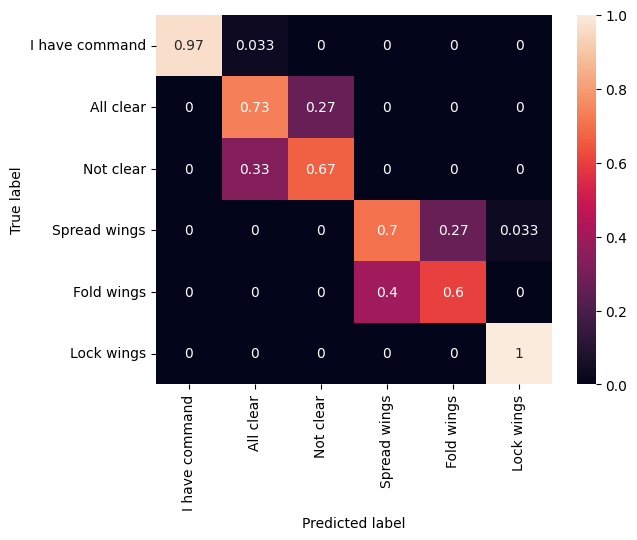

In [98]:
label_list = pipeline.steps[4][1].classes_
cf = confusion_matrix(test_labels, preds, labels=label_list).astype(float)
for i in range(len(cf)):
    cf[i] = [x / cf[i].sum() for x in cf[i]]    
label_dict = {'1': 'I have command',  '2': 'All clear',  '3': 'Not clear', '4': 'Spread wings', '5': 'Fold wings', '6': 'Lock wings'}
text_labels = [label_dict[i] for i in label_list]
sns.heatmap(cf, annot=True, xticklabels=text_labels, yticklabels=text_labels)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [99]:
comte = explainers.OptimizedSearch(pipeline, timeseries, labels, silent=False, threads=4,num_distractors=2)

In [100]:
### TEST CASE 1
### True: 2 All clear, Predicted: 3 Not clear

true_select = 2 #UPDATE HERE FOR OTHER CLASSES
pred_select = 3 #UPDATE HERE FOR OTHER CLASSES

indices_test = []
for idx, (true, pred) in enumerate(zip(test_labels['label'].values, preds)):
    if true ==  str(true_select) and pred == str(pred_select):
        indices_test.append(idx)

In [101]:
x_test.shape

(51, 24)

2023-11-17 00:38:17,216 INFO    Working on turning label from 3 to 4
2023-11-17 00:38:17,289 INFO    Finished constructing per class kdtree
2023-11-17 00:38:17,290 INFO    Returning distractors [109, 42]
2023-11-17 00:38:17,291 INFO    Trying distractor 1 / 2
2023-11-17 00:38:34,428 INFO    Current probas: [[0.1  0.23 0.37 0.13 0.06 0.11]]
2023-11-17 00:38:34,429 INFO    Trying distractor 2 / 2
2023-11-17 00:38:51,390 INFO    Current probas: [[0.05 0.19 0.32 0.13 0.05 0.26]]
2023-11-17 00:38:51,391 INFO    Used greedy search for 6
2023-11-17 00:38:51,396 INFO    Working on turning label from 2 to 3
2023-11-17 00:38:51,397 INFO    Returning distractors [109, 42]
2023-11-17 00:38:51,398 INFO    Trying distractor 1 / 2
2023-11-17 00:38:51,401 INFO    Current probas: [[0.15 0.3  0.5  0.   0.   0.05]]
2023-11-17 00:38:51,498 INFO    Best column: Hand tip left, X, best case: 0.07
/mnt/d/research/craven/baselines/CoMTE/explainers.py:104: UserWarning: FigureCanvasAgg is non-interactive, and th

###########
['Hand tip left, X', 'Hand tip left, Y', 'Hand tip right, X', 'Wrist left, Y', 'Thumb left, X']
###########


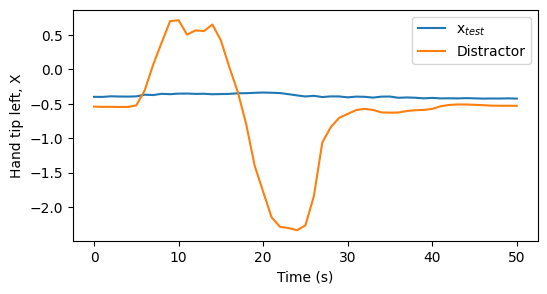

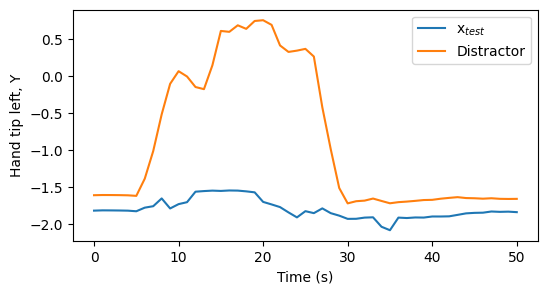

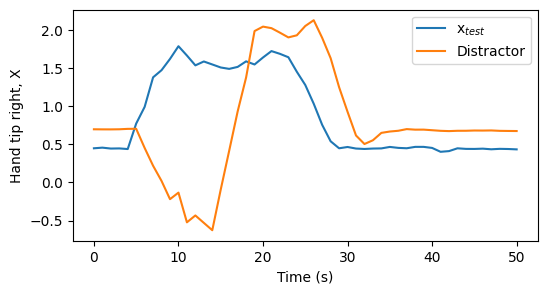

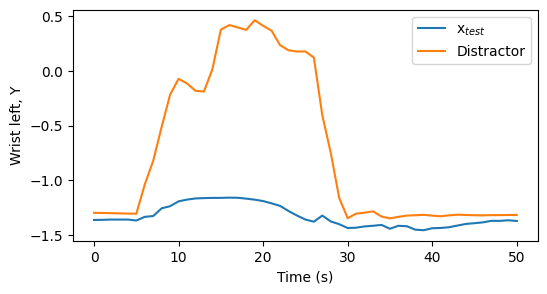

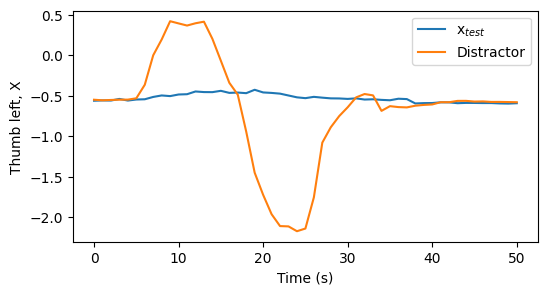

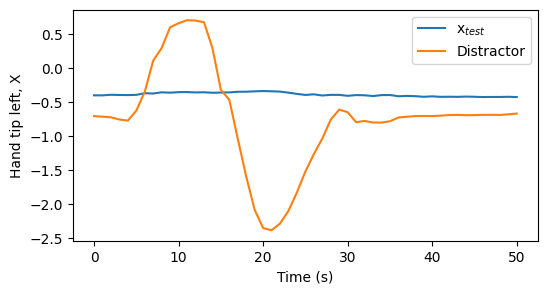

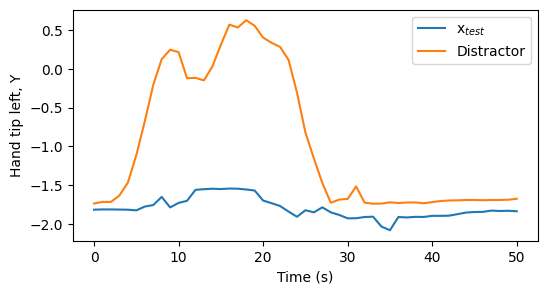

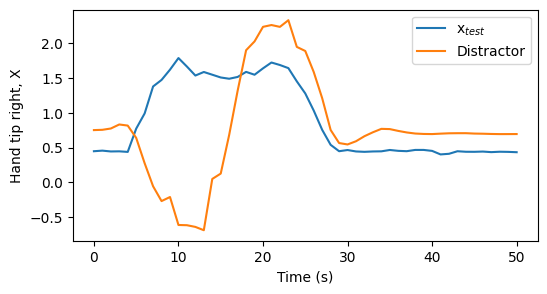

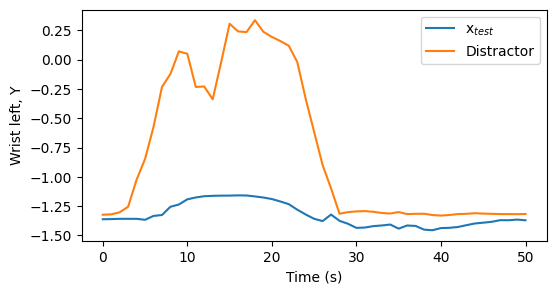

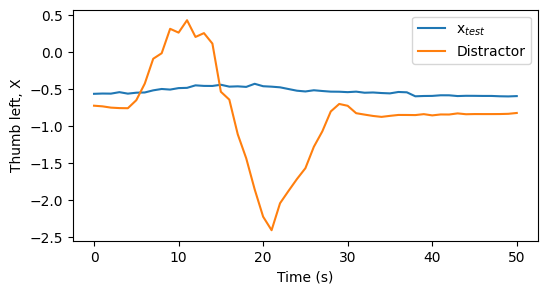

In [102]:
for ind in indices_test:
    x_test = test_timeseries.loc[[ind], :, :]
    explanation = comte.explain(x_test,to_maximize=pred_select,savefig=False) 
    print('###########')
    print(explanation)
    print('###########')
    break

In [103]:
explanation

['Hand tip left, X',
 'Hand tip left, Y',
 'Hand tip right, X',
 'Wrist left, Y',
 'Thumb left, X']